In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/Test.zip"
!unzip "/content/gdrive/My Drive/Training.zip"

In [ ]:
import os 
import random
import shutil


In [ ]:
os.mkdir('Validation')
os.mkdir('Validation/Fire')
os.mkdir('Validation/No_Fire')

In [ ]:
#Creating validation folder and moving randomly selected images from traning folder to validation folder
random.seed(126)
source = 'Training/Fire'
dest = 'Validation/Fire'
files = os.listdir(source)
no_of_files = len(files) // 6

for file_name in random.sample(files, no_of_files):
    shutil.move(os.path.join(source, file_name), dest)


In [ ]:
#Creating validation folder and moving randomly selected images from traning folder to validation folder
random.seed(19)
source = 'Training/No_Fire'
dest = 'Validation/No_Fire'
files = os.listdir(source)
no_of_files = len(files) // 6

for file_name in random.sample(files, no_of_files):
    shutil.move(os.path.join(source, file_name), dest)


In [ ]:
import numpy as np
from tqdm import tqdm
from random import shuffle
import cv2
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Conv2D, MaxPooling2D
from keras.layers import Dropout
from keras.layers import Dense
from keras.optimizers import Adam, RMSprop
from sklearn.metrics import classification_report
from skimage.color import rgb2hsv
import skimage

In [ ]:
Train_path = 'Training'
Test_path = 'Test'
Validation_path ='Validation'

In [ ]:
from skimage.color import rgb2hsv
def color_aug(img):
  img = img / 255
  new_img = rgb2hsv(img) * 255
  return new_img

In [ ]:
def noise(img):
    img = img / 255
    gimg = skimage.util.random_noise(img, mode='poisson') * 255
    return gimg 

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=45,
                                   #horizontal_flip = True,
                                   vertical_flip=True,
                                   #width_shift_range=0.2,
                                   #height_shift_range=0.2,
                                   #fill_mode='reflect',
                                   #brightness_range=[0.5, 1.5]
                                   #preprocessing_function=noise
                                   )

validation_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    Train_path,
    target_size=(254, 254),
    batch_size=64,
    color_mode='rgb',
    class_mode='binary',
    shuffle=True) # set as training data

validation_generator = validation_datagen.flow_from_directory(
    Validation_path, 
    target_size=(254, 254),
    color_mode='rgb',
    batch_size=64,
    class_mode='binary', shuffle=False) # set as validation data

test_generator = test_datagen.flow_from_directory(
        Test_path,
        target_size=(254, 254),
        color_mode='rgb',
        batch_size=1,
        class_mode='binary', shuffle=False)

Found 32814 images belonging to 2 classes.
Found 6561 images belonging to 2 classes.
Found 8617 images belonging to 2 classes.


In [ ]:
train_generator.class_indices

{'Fire': 0, 'No_Fire': 1}

**DenseNet**

In [ ]:
from keras.applications import DenseNet121
densenet_v2 = DenseNet121(
    include_top=False,
    input_shape=(254,254,3))
model = Sequential()
model.add(densenet_v2)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.6))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.000075),
              metrics=['accuracy'])

In [ ]:
history = model.fit(
          train_generator,
          steps_per_epoch = train_generator.samples // 64,
          validation_data = validation_generator, 
          validation_steps = validation_generator.samples // 64,
          epochs = 5)

Epoch 1/5
512/512 [==============================] - 517s 966ms/step - loss: 0.1312 - accuracy: 0.9472 - val_loss: 0.0132 - val_accuracy: 0.9968
Epoch 2/5
512/512 [==============================] - 489s 954ms/step - loss: 0.0100 - accuracy: 0.9975 - val_loss: 0.0030 - val_accuracy: 0.9992
Epoch 3/5
512/512 [==============================] - 481s 938ms/step - loss: 0.0079 - accuracy: 0.9979 - val_loss: 0.0042 - val_accuracy: 0.9991
Epoch 4/5
512/512 [==============================] - 474s 925ms/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 0.0017 - val_accuracy: 0.9997
Epoch 5/5
512/512 [==============================] - 475s 927ms/step - loss: 0.0077 - accuracy: 0.9984 - val_loss: 0.0049 - val_accuracy: 0.9991


In [ ]:
predictions = model.predict(test_generator)

In [ ]:
test_labels=test_generator.classes 

y_pred = [1 * (x[0]>=0.5) for x in predictions]

print(classification_report(test_labels, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      5137
           1       0.89      0.95      0.92      3480

    accuracy                           0.93      8617
   macro avg       0.93      0.94      0.93      8617
weighted avg       0.93      0.93      0.93      8617



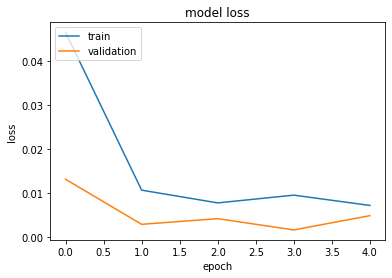

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

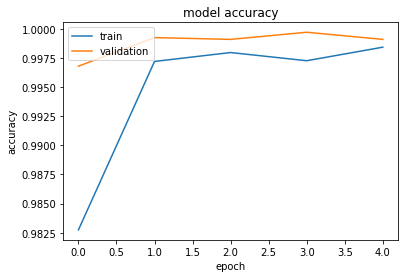

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
